In [2]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sys,os,time
import tensorflow as tf
from contextlib import contextmanager
from math import ceil, floor
import cv2
from tensorflow.contrib.layers import flatten
%matplotlib inline

@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def plot(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap="gray")
    plt.show()

In [3]:
## Load pickled data
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


Propotion of classes in training examples: 
[ 0.00517256  0.05689819  0.05776028  0.03620794  0.05086353  0.04741516
  0.01034512  0.03707003  0.03620794  0.03793212  0.05172562  0.03362166
  0.05431191  0.055174    0.01982816  0.01551769  0.01034512  0.02844909
  0.03103537  0.00517256  0.00862094  0.00775884  0.00948303  0.01293141
  0.00689675  0.03879422  0.01551769  0.00603466  0.0137935   0.00689675
  0.01120722  0.01982816  0.00603466  0.01721314  0.01034512  0.03103537
  0.00948303  0.00517256  0.05344981  0.00775884  0.00862094  0.00603466
  0.00603466]

Summary for data sets: 
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Visualization for propotion of labels in train data set: 


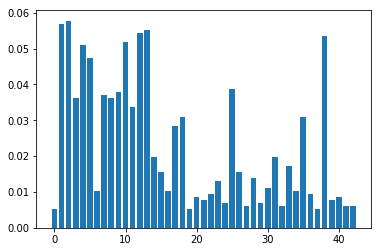


Visualization for few images from train: 


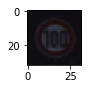

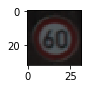

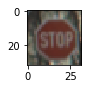

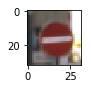

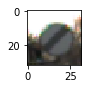

SystemExit: 1

/Users/yuanpingzhou/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
## basic info of data sets and visualization
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

# What propotions do these classes/labels take?
p_classes = dict((c, 0) for c in range(n_classes))
for l in y_train:
    p_classes[l] += 1
print('\nPropotion of classes in training examples: ')
print(np.divide(list(p_classes.values()),np.sum(list(p_classes.values()))))

print('\nSummary for data sets: ')
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# visualization for the propotion of labels in train data set
print('\nVisualization for propotion of labels in train data set: ')
p = list(np.divide(list(p_classes.values()),np.sum(list(p_classes.values()))))
x = np.argsort(p)
y = np.sort(p)
plt.subplot(111)
plt.bar(x, y)
plt.savefig('label_propotions.jpg')
plt.show()

# visualization for few images from train
print('\nVisualization for few images from train: ')
for i in range(5):
    index = random.randint(0, len(X_train))
    plot(X_train[index])
    cv2.imwrite('x_%s.jpg' % i, X_train[index])
    
sys.exit(1)

In [ ]:
IMAGE_SIZE = 32

## visualization for image
def plot(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")
    plt.show()
    
## random brightness for image
def random_brightness(img):
    
    image = tf.identity(img)
    
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)   
    image = tf.cast(image, tf.uint8)
    
    return image
# random noise for image
def random_noise(img):
    
    image = tf.identity(img)
    
    white_mask = tf.fill([32, 32, 3], np.uint8(255))
    threshold_mask = tf.fill([32, 32, 3], np.float32(0.1))
    noise_img = tf.random_normal(shape= [32, 32, 3], mean= .0, stddev= 0.1, dtype= tf.float32)
    noise_mask = tf.multiply(tf.cast(tf.greater(noise_img, threshold_mask), tf.uint8), white_mask)
    
    image = tf.cast(tf.maximum(tf.cast(image, tf.int32), tf.cast(noise_mask, tf.int32)), tf.uint8)
    
    return image

# fixed deep-brightness for image
def fixed_brightness(X_imgs):
    
    n_samples = len(X_imgs)
    brightened_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    bright_weight = [0.15, 0.25]
    
    for w in bright_weight:
        for i in range(n_samples):
            img = X_imgs[i].copy()
            gaussian = np.random.random((row, col, 1)).astype(np.float32)
            gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
            img = img.astype(np.float32)/255
            gaussian_img = cv2.addWeighted(img, w, 0.25 * gaussian, 0.25, 0)
            gaussian_img = (gaussian_img * 255).astype(np.uint8).tolist()
            brightened_imgs.append(gaussian_img)
            
    return brightened_imgs
# paint white on black part
def paintwhite1(img):

    image = tf.identity(img)
    
    m1 = tf.cast(tf.less(image, tf.fill([32, 32, 3], np.uint8(65))), tf.uint8)
    white_img = tf.fill([32, 32, 3], np.uint8(255))
    
    image = tf.maximum(tf.cast(image, tf.int32), tf.cast(tf.multiply(white_img, m1), tf.int32))
    image = tf.cast(image, tf.uint8)
    
    return image
# paint white on red part
def paintwhite2(img):
    
    image = tf.identity(img)
    
    m1 = tf.cast(tf.less(image, tf.fill([32, 32, 3], np.uint8(120))), tf.uint8)
    m2 = tf.cast(tf.greater(image, tf.fill([32, 32, 3], np.uint8(65))), tf.uint8)
    m = tf.multiply(m1, m2)
    white_img = tf.fill([32, 32, 3], np.uint8(255))
    
    image = tf.maximum(tf.cast(image, tf.int32), tf.cast(tf.multiply(white_img, m), tf.int32))
    image = tf.cast(image, tf.uint8)
    
    return image

## random scale for image
def random_scale(img):
    
    image = tf.identity(img)
    
    image = tf.divide(tf.cast(image, tf.float32), 255)
    image = tf.random_crop(image, size=[24, 24, 3])
    image = tf.image.resize_images(image, (32, 32))
    image = tf.cast(tf.multiply(image, 255.0), tf.uint8)
    
    return image
# get translate params
def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

## augmentation for train images
def augment_data(dataset, dataset_labels, augementation_factor= 4):
    augmented_image = []
    augmented_image_labels = []

    img_input = tf.placeholder(tf.uint8, (32, 32, 3))
    # random brightness
    bright = random_brightness(img_input)
    # scale
    scale = random_scale(img_input)
    # random noise
    noise = random_noise(img_input)
    # paint white
    paint = paintwhite1(img_input)
    
    n = 0
    with tf.Session() as sess:
        for num in range (0, dataset.shape[0]):
            # original image
            augmented_image.append(dataset[num].tolist())
            augmented_image_labels.append(dataset_labels[num])
            for i in range(0, augementation_factor):
                # random brightness for image
                result_img = sess.run(bright, feed_dict= {img_input: dataset[num]})
                augmented_image.append(result_img.tolist())
                augmented_image_labels.append(dataset_labels[num])
                # random scale for image
                result_img = sess.run(scale, feed_dict= {img_input: dataset[num]})
                augmented_image.append(result_img.tolist())
                augmented_image_labels.append(dataset_labels[num])
#                 # paint
#                 result_img = sess.run(paint, feed_dict= {img_input: dataset[num]})
#                 augmented_image.append(result_img.tolist())
#                 augmented_image_labels.append(dataset_labels[num])
            # random noise for image
            result_img = sess.run(noise, feed_dict= {img_input: dataset[num]})
            augmented_image.append(result_img.tolist())
            augmented_image_labels.append(dataset_labels[num])
                
            if((n % 1000) == 0):
                print('%s done.' % n)
            n += 1
#         # translation for images
#         offsets = np.zeros((dataset.shape[0], 2), dtype = np.float32)
#         n_translations = 4
#         for i in range(n_translations):
#             X_translated = np.zeros((dataset.shape[0], 32, 32, 3), dtype = np.float32)
#             X_translated.fill(1.0) # Filling background color
#             base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
#             offsets[:, :] = base_offset 
#             glimpses = tf.image.extract_glimpse(dataset/255.0, size, offsets)   
#             glimpses = sess.run(glimpses)
#             X_translated[:, h_start: h_start + size[0], w_start: w_start + size[1], :] = glimpses
#             augmented_image.extend((np.array(X_translated) * 255.0).astype(np.uint8).tolist())
#             augmented_image_labels.extend(dataset_labels)
        # add fixed deep-brightness for images as deep-darkness exists in certain kinds of images
        augmented_image.extend(fixed_brightness(dataset))
        augmented_image_labels.extend(dataset_labels)
        augmented_image_labels.extend(dataset_labels)
    return np.array(augmented_image).astype(np.uint8), np.array(augmented_image_labels)

print('original shape: ')
print(X_train.shape)
print(y_train.shape)
with timer('Augmentation '):
    X_train, y_train = augment_data(X_train, y_train) # it's a time-consuming preprocess
print('augmented shape: ')
print(X_train.shape)
print(y_train.shape)

## debugging for certain kind of images
# label = 0
# idx = np.argwhere(y_train == label).flatten()
# print('size label %s is %s' % (label, len(idx)))
# print(X_train.shape)
# X_train_1 = X_train[idx,]
# y_train_1 = y_train[idx,]
# print(X_train_1.shape)
# tmp_x = X_train_1[:1,]
# tmp_y = y_train_1[:1,]
# print(tmp_x.shape)
# tmp_x, tmp_y = augment_data(tmp_x, tmp_y)
# tmp_x = tmp_x.astype(np.uint8)
# for i in range(len(tmp_x)):
#     plot(tmp_x[i])
# sys.exit(1)

In [ ]:
## LE-Net architechure
# add dropout for these two convolutional layer to avoid overfitting after adding few times of augmentation images
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob_1, keep_prob_2):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    filter_1= 6
    filter_2= 16
    full_1 = 120
    full_2 = 84
    full_3 = 43
    
    # Layer 1: Convolutional. Input = 32x32x3. 
    # out_height = (32 - 5 + 1)/1 = 28,
    # out_width = (32 - 5 + 1)/1 = 28,
    # out_depth = 6(tunned)
    # Output = 28 * 28 * 6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, filter_1), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(filter_1))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1_size = int((32 - 5 + 1)/1)
    
    # Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob_1)

    # Pooling. Input = 28x28x6. 
    # out_height = (28 - 2 + 2)/2 = 14,
    # out_width = (28 - 2 + 2)/2 = 14,
    # out_depth = 6(handed by conv1)
    # Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1_size = int((conv1_size - 2 + 2)/2)
    
    # Layer 2: Convolutional. 
    # out_height = (14 - 5 + 1)/1 = 10,
    # out_width = (14 - 5 + 1)/1 = 10,
    # out_depth = 16(tunned)
    # Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, filter_1, filter_2), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(filter_2))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2_size = int((conv1_size - 5 + 1)/1)
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob_2)

    # Pooling. Input = 10x10x16. 
    # out_height = (10 - 2 + 2)/2 = 5,
    # out_width = (10 - 2 + 2)/2 = 5,
    # out_depth = 16(handed by conv2)
    # Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2_size = int((conv2_size - 2 + 2)/2)
    
    # Flatten. Input = 5x5x16.
    # Output = 5 * 5 * 16 = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(conv2_size * conv2_size * filter_2, full_1), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(full_1))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(full_1, full_2), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(full_2))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(full_2, full_3), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(full_3))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [ ]:
## super-parameters
rate = 0.001
EPOCHS = 20
BATCH_SIZE = 512

## TF logic for optimization 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

logits = LeNet(x, keep_prob_1, keep_prob_2)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## TF logic for evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

## have the dropout rate being 1.0 while inferring
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_1: 1.0, keep_prob_2: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## training/evaluation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_1: 0.5, keep_prob_2: 0.8})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

In [ ]:
## prediction on test
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
## analysis on new images downloaded on the web with top-k softmax probabilities
softmax = tf.nn.softmax(logits)

t1 = cv2.imread('speed_limit_60.jpg')
t2 = cv2.imread('turn_left.jpg')
t3 = cv2.imread('speed_limit_70.jpg')
t4 = cv2.imread('stop.jpg')
t5 = cv2.imread('end_of_speed.jpg')
labels_web = [3, 34, 4, 14, 6]
img_web = []

print('\nVisualization for the new images from web: ')
for test_img in [t1, t2, t3, t4, t5]:
    img_web.append(cv2.resize(test_img, (32, 32)).tolist())
for i in range(len(img_web)):
    plot(img_web[i])
    print('Label %s' % labels_web[i])
img_web = np.array(img_web)
print('\nShape of images from web: ')
print(img_web.shape)

k = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    pred_y = sess.run(softmax, feed_dict={x: img_web, keep_prob_1: 1.0, keep_prob_2: 1.0})
    topk = sess.run(tf.nn.top_k(tf.constant(pred_y), k= k))
    
    ## top-k softmax value
    print('\nTop-%s softmax probabilities for new images from web: ' % k)
    print(topk.values)
    print('\nPredicted labels for new images from web: ')
    print(topk.indices)

In [ ]:
def plot(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap="gray")
    plt.show()

## analysis with top-k lowest recall for individual labels
one_hot_pred = tf.one_hot(tf.argmax(softmax, 1), 43)
# y_pred_equal = tf.equal(one_hot_y, one_hot_pred)
y_pred_mult = tf.multiply(one_hot_y, one_hot_pred)
tp = tf.reduce_sum(y_pred_mult, 0)
t_n = tf.reduce_sum(one_hot_y, 0)

# collect top-k labels with lowest recall
k = 10
num_examples = len(X_test)
print('Total size for test %s ' % num_examples)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(tf.local_variables_initializer())

    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_test[offset: offset + BATCH_SIZE]
        batch_y = y_test[offset: offset + BATCH_SIZE]
        if(offset == 0):
            tp_mat = sess.run(tp, feed_dict={x: batch_x, y: batch_y, keep_prob_1: 1.0, keep_prob_2: 1.0})
            t_n_mat = sess.run(t_n, feed_dict={y: batch_y})
        else:
            tp_mat = np.vstack([tp_mat, sess.run(tp, feed_dict={x: batch_x, y: batch_y, keep_prob_1: 1.0, keep_prob_2: 1.0})])
            t_n_mat = np.vstack([t_n_mat, sess.run(t_n, feed_dict={y: batch_y})])
    individual_recall = np.sum(tp_mat, 0) / np.sum(t_n_mat, 0)
    print('\nRecall for labels with the top-%s lowest recall: ' % k)
    topk_recall = np.sort(individual_recall[:k])
    print(topk_recall)
    print('\nLabels with the top-%s lowest recall: ' % k)
    topk_label = np.argsort(individual_recall)[:k]
    print(topk_label)   
# visualize some of these misclassified image
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    pred_mat = sess.run(one_hot_pred, feed_dict= {x: X_test, keep_prob_1: 1.0, keep_prob_2: 1.0})
    y_mat = sess.run(one_hot_y, feed_dict={y: y_test}) 
    y_pred_mult_mat = np.multiply(pred_mat, y_mat)
    # for label 27
    debug_label = 30
    print('\nDebugging for label %s: ' % debug_label)
    pos_idx = np.argwhere(np.transpose(y_mat[:, debug_label]) == 1).flatten()
    pred_pos_idx = np.argwhere(np.transpose(pred_mat[:, debug_label]) == 1).flatten()
    print('\nIndex of truth postive: ')
    print(pos_idx)
    print('\nIndex of predicted positive: ')
    print(pred_pos_idx)
    mis_pos_idx = [v for v in pos_idx if(v not in pred_pos_idx)]
    print('\nSize of misclassified label %s is %s: ' % (debug_label, len(mis_pos_idx)))
    print('\nIndex of misclassified positive: ')
    print(mis_pos_idx)
    mis_pred_label = np.argmax(pred_mat[mis_pos_idx,:], 1)
    print('\nMisclassified label for label %s: ' % debug_label)
    print(mis_pred_label)
    # sample the last 10 misclassified image, visualize them, see what characters they reside
    s = 5
    for i in range(s):
        img = X_test[mis_pos_idx[-(s - i)]].squeeze()
        plot(img)
        print('predicted label %s' % mis_pred_label[- (s - i)])
        
## notable charactertics of misclassified labels
# 1. darkness seems like a pretty common feature within all kinds of images, assuming these images were captured at night
# 2. noising pixels, assuming these signs were damaged in some way
# 3. scale size, assuming these images were captured with different angle and distance
## improvement augmentation strategies
# 1. brightenness for images
# 2. add perputation noise
# 3. zoom(scale) in/out for images